In [1]:
import pandas as pd
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import random
from sklearn.preprocessing import  OneHotEncoder

In [2]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Dense
from keras.layers import Flatten, Activation, Concatenate
from keras.losses import categorical_crossentropy
from keras.optimizers import adam
import keras.backend as K

Using TensorFlow backend.


In [3]:
FOLDER = '../../data_kaggle/kuzushiji/'
IMAGES = FOLDER + 'train_images/'
CHARS = FOLDER + 'chars/'
MODELS = FOLDER + 'models/'
print(os.listdir(FOLDER))

['unicode_translation.csv', 'train_images', 'sample_submission.csv', 'train.csv', 'kuzushiji-recognition.zip', 'output', 'test_images', 'chars', 'models']


In [4]:
from ssd_utils.ssd_cnn import SSD_CNN
from ssd_utils.ssd_box import DefaultBox, BBoxUtility
from ssd_utils.ssd_gen import Generator
from ssd_utils.ssd_training import MultiboxLoss

In [5]:
df_train = pd.read_csv(FOLDER + 'train.csv')
df_sub = pd.read_csv(FOLDER + 'sample_submission.csv')
unicode_map = {codepoint: char for codepoint, char in pd.read_csv(FOLDER + 'unicode_translation.csv').values}

with open(MODELS + 'ohe.pickle', 'rb') as f:
    ohe = pickle.load(f)

In [6]:
df_sub_idx = df_sub.set_index("image_id")
df_train_idx = df_train.set_index("image_id")
idx_train = df_train['image_id']

In [7]:
num_classes = len(unicode_map)

In [8]:
DB = DefaultBox((300,300,1), 10, 100, [2,3], [0.1, 0.1, 0.2, 0.2]) 
DB.compute_output_shape(np.array([1,10,20]))
# var = K.ones(shape=( 100, 100))
# priors = K.eval(DB(var))

(1, 1200, 8)

In [9]:
var1 = K.ones(shape=(1, 21, 21))
priors1 = K.eval(DB(var1)).reshape(-1,8)

var2 = K.ones(shape=(1, 11, 11))
priors2 = K.eval(DB(var2)).reshape(-1,8)

var3 = K.ones(shape=(1, 10, 10))
priors3 = K.eval(DB(var3)).reshape(-1,8)

priors = np.vstack([priors1,  priors2])

In [10]:
BBU = BBoxUtility(num_classes, priors)

In [11]:
len_idx = len(idx_train)
rand_idx = random.sample(list(idx_train), len_idx)
train_keys = rand_idx[:int(len_idx*0.8)]
val_keys = rand_idx[int(len_idx*0.8):]

In [12]:
BBU = BBoxUtility(num_classes, priors)

df_idx = df_train_idx 
bbox_util = BBU
batch_size = 4
path_prefix = IMAGES
image_size = (1000, 1000, 1)

gen =  Generator(df_idx = df_train_idx, 
                 bbox_util = BBU,
                 batch_size = batch_size,
                 path_prefix = IMAGES,
                 ohe = ohe,
                 train_keys = train_keys,
                 val_keys = val_keys,
                 image_size=image_size)

In [13]:
ssd_obj = SSD_CNN(num_classes, cnn_size=(100, 100, 1), ssd_size=image_size)
cnn_model = ssd_obj.load(MODELS + 'model.hdf5')
ssd_model = ssd_obj.build_ssd()

In [14]:
ssd_model.compile(optimizer=adam(), 
                  loss=MultiboxLoss(num_classes, neg_pos_ratio=10.0).compute_loss)

In [15]:
ssd_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ssd_input (InputLayer)          (None, 1000, 1000, 1 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 1000, 1000, 3 288         ssd_input[0][0]                  
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 1000, 1000, 3 9216        conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 500, 500, 32) 0           conv1_2[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [ ]:
history = ssd_model.fit_generator(gen.generate(True),
                                  steps_per_epoch=gen.train_batches,
                                  epochs=4,
                                  verbose=1,
                                  validation_data=gen.generate(False),
                                  validation_steps=gen.val_batches)

Epoch 1/4
   6/3104 [..............................] - ETA: 1:40:16 - loss: 10.8978

In [17]:
key = idx_train[0]
img_path = path_prefix + key + '.jpg'
img_path

'../../data_kaggle/kuzushiji/train_images/100241706_00004_2.jpg'

In [18]:
from keras.preprocessing import image

In [19]:
img = image.load_img(img_path, target_size=image_size[:2])
img = image.img_to_array(img)/255

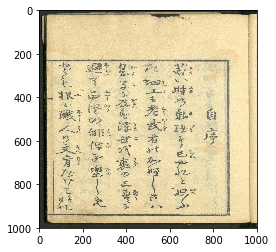

In [20]:
plt.imshow(img)
plt.show()

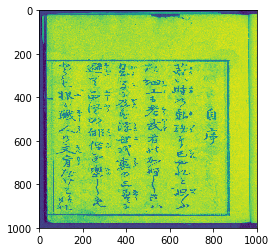

In [21]:
img_gray = img.dot([0.299, 0.587, 0.114])
plt.imshow(img_gray)
plt.show()

In [26]:
pred = ssd_model.predict(img_gray[np.newaxis, :, :, np.newaxis])

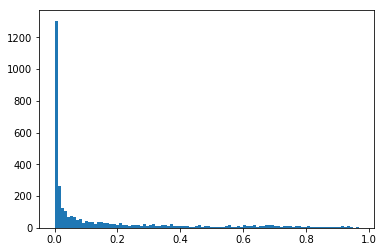

In [27]:
plt.hist(pred[0,:, 4:-8][:,0], bins=100)
plt.show()

In [28]:
pd.Series(ohe.inverse_transform(pred[0,:, 4:-8]).reshape(-1)).value_counts()

U+0031    3161
U+4EA4      20
U+502D      18
U+682A      17
U+5546      15
U+9AA8      13
U+608C      12
U+6839      10
U+968E       9
U+4F3A       9
U+7531       7
U+7D44       7
U+826F       6
U+9583       6
U+5E7D       5
U+76D7       5
U+874E       5
U+4F3C       4
U+96EA       4
U+5B5D       3
U+6897       2
U+7CBE       2
U+8188       2
U+7B92       2
U+7A3B       2
U+821B       2
U+6108       2
U+99B4       2
U+7269       1
U+7D14       1
U+5C45       1
U+30AE       1
U+6CB9       1
U+4C99       1
U+5C3A       1
U+596E       1
U+690D       1
U+5B87       1
U+84C9       1
U+6749       1
U+6E1F       1
U+7BE9       1
U+76DB       1
U+6298       1
U+5165       1
U+67C4       1
U+4EF2       1
U+68B5       1
dtype: int64

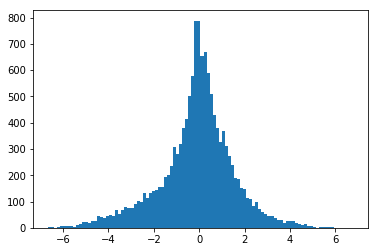

In [29]:
plt.hist(pred[0,:, :4].reshape(-1), bins=100)
plt.show()

In [26]:
unicode_map['U+0031']

'1'